# Importing/installing libraries

---



In [ ]:
# !pip install opencv-python
# !pip install albumentations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Core Python libraries
import os
import math
import random

# Data processing and scientific computation
import numpy as np
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import pairwise_distance
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models

# Image processing
import cv2
from PIL import Image

# File operations
import shutil
import json

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Preprocessing

---



## Dataset estimation

In [ ]:
character_counts = {}
input_dir = '/content/drive/MyDrive/AI/simpsons/simpsons_dataset'

# Counting images for all characters (listdir)
for character_folder in os.listdir(input_dir):
    character_folder_path = os.path.join(input_dir, character_folder)

    if os.path.isdir(character_folder_path):
        num_files = len([f for f in os.listdir(character_folder_path)])
        character_counts[character_folder] = num_files

In [ ]:
# Sorting characters by number of images (ascending)
sorted_counts = sorted(character_counts.items(), key=lambda x: x[1])
# character_list = []

print("Number of images per character:")
for character, count in sorted_counts:
    print(f"{character}: {count} images")
    # character_list.append(character)

Number of images per character:
simpsons_dataset: 42 images
abraham_grampa_simpson: 1400 images
apu_nahasapeemapetilon: 1400 images
agnes_skinner: 1400 images
barney_gumble: 1400 images
bart_simpson: 1400 images
carl_carlson: 1400 images
charles_montgomery_burns: 1400 images
fat_tony: 1400 images
edna_krabappel: 1400 images
gil: 1400 images
chief_wiggum: 1400 images
comic_book_guy: 1400 images
cletus_spuckler: 1400 images
disco_stu: 1400 images
groundskeeper_willie: 1400 images
kent_brockman: 1400 images
lenny_leonard: 1400 images
krusty_the_clown: 1400 images
lionel_hutz: 1400 images
maggie_simpson: 1400 images
lisa_simpson: 1400 images
marge_simpson: 1400 images
mayor_quimby: 1400 images
martin_prince: 1400 images
milhouse_van_houten: 1400 images
miss_hoover: 1400 images
nelson_muntz: 1400 images
otto_mann: 1400 images
patty_bouvier: 1400 images
selma_bouvier: 1400 images
rainier_wolfcastle: 1400 images
sideshow_mel: 1400 images
ralph_wiggum: 1400 images
sideshow_bob: 1400 images
pro

## Augmentations

### List of augmentations

In [ ]:
albumentation_list = [A.RandomFog(p=1),
                      A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1),
                      A.HorizontalFlip(p=1),
                      A.VerticalFlip(p=1),
                      A.RandomBrightnessContrast(p=1.0),
                      A.GaussNoise(std_range=[0.1, 0.2], p=1.0),
                      A.HueSaturationValue(p=1.0, hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20),
                      A.Blur(p=1.0),
                      A.Downscale(scale_range=[0.3, 0.3], p=1.0),
                      A.SaltAndPepper(p=1.0),
                      A.ISONoise(p=1.0),
                      A.RandomGamma(p=1.0),
                      A.Posterize(p=1.0)
]

### Augmentation visualisation (to choose suitable ones)

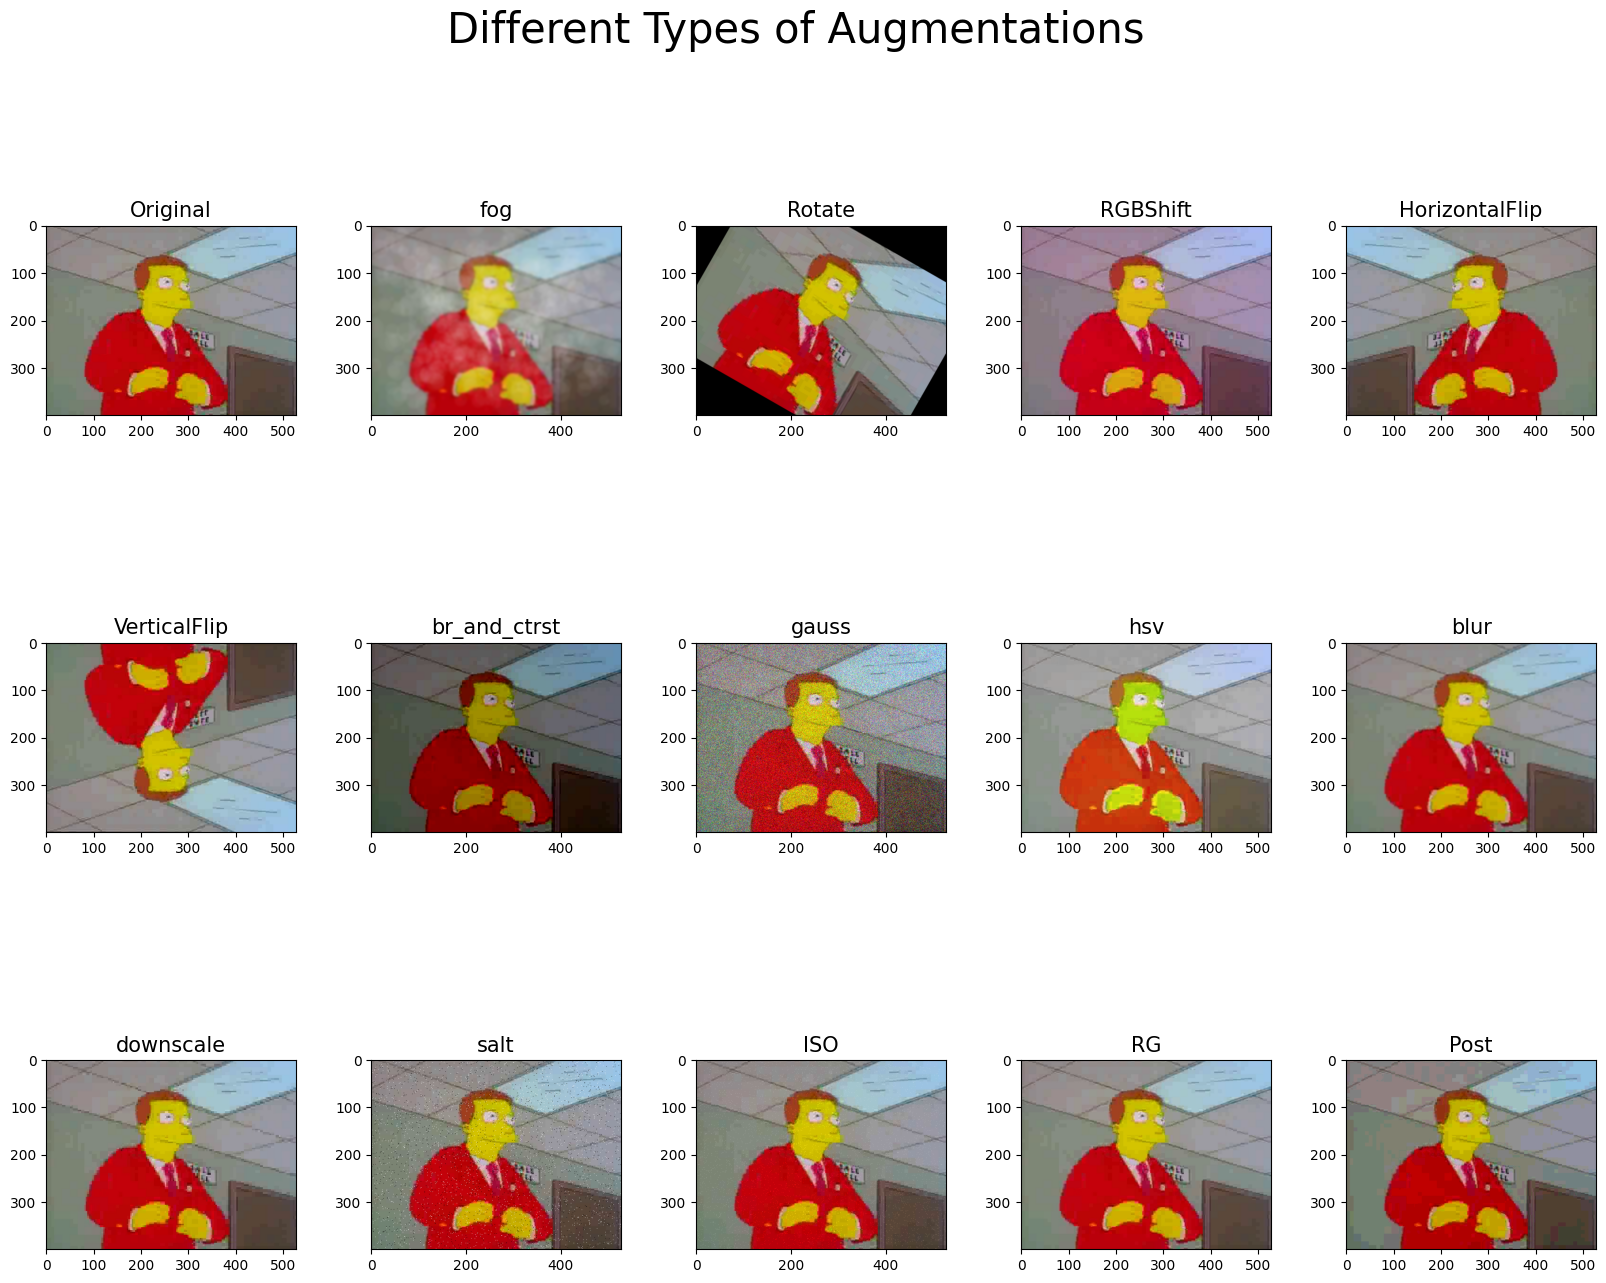

In [ ]:
import cv2


image_folder_path = '/content/drive/MyDrive/AI/simpsons/simpsons_dataset/lionel_hutz'
chosen_image = cv2.imread(os.path.join(image_folder_path, "pic_0000.jpg"))[:,:,::-1]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)

titles_list = ["Original","fog",
               "Rotate", "RGBShift","HorizontalFlip",
               "VerticalFlip","br_and_ctrst", "gauss", "hsv", "blur", "downscale",
               "salt", "ISO", "RG", "Post"]

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=3, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()


plot_multiple_img(img_matrix_list, titles_list, ncols = 5,main_title="Different Types of Augmentations")

### Augmentation functions

In [ ]:
def apply_augmentation(image, idx):
    transform = A.Compose(albumentation_list[idx]) # Choosing one augmentation
    augmented = transform(image=image)

    return augmented['image']

In [ ]:
def augment_images_in_folder(folder_path, n_augm):
    '''
    Applying augmentations from the list above (albumentation_list).
    Augmentations are applied until the number of images for a character is equal to n_augm.
    '''

    filelist = os.listdir(folder_path)
    initial_count = len(filelist) # Number of images before augmentations
    augm_idx = 0

    # Calculate the number of additional images needed
    additional_images = n_augm - initial_count

    if additional_images <= 0:
        print("The desired number of images is already present or exceeded.")
        return

    # Loop until the desired number of images is reached
    while len(os.listdir(folder_path)) < n_augm:
        for filename in filelist:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                if len(os.listdir(folder_path)) >= n_augm:
                    break

                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path)

                # Apply an augmentation (one per image)
                augm_img = apply_augmentation(image, augm_idx)
                augm_idx = (augm_idx + 1) % len(albumentation_list) # Augmentations applied in circle

                # Save the augmented image with a unique name
                out_filename = f'augmented_{len(os.listdir(folder_path)) + 1}_{filename}'
                out_path = os.path.join(folder_path, out_filename)
                cv2.imwrite(out_filename, augm_img)
                print(f'Augmented image saved to {out_filename}')

### List of characters in dataset

In [3]:
# 42 characters
classes = ['lionel_hutz',
 'disco_stu',
 'troy_mcclure',
 'miss_hoover',
 'fat_tony',
 'gil',
 'otto_mann',
 'sideshow_mel',
 'agnes_skinner',
 'rainier_wolfcastle',
 'cletus_spuckler',
 'snake_jailbird',
 'professor_john_frink',
 'martin_prince',
 'patty_bouvier',
 'ralph_wiggum',
 'carl_carlson',
 'selma_bouvier',
 'barney_gumble',
 'groundskeeper_willie',
 'maggie_simpson',
 'waylon_smithers',
 'mayor_quimby',
 'lenny_leonard',
 'nelson_muntz',
 'edna_krabappel',
 'comic_book_guy',
 'kent_brockman',
 'apu_nahasapeemapetilon',
 'sideshow_bob',
 'abraham_grampa_simpson',
 'chief_wiggum',
 'milhouse_van_houten',
 'charles_montgomery_burns',
 'principal_skinner',
 'krusty_the_clown',
 'marge_simpson',
 'bart_simpson',
 'lisa_simpson',
 'moe_szyslak',
 'ned_flanders',
 'homer_simpson']

### Augmentations applying

In [ ]:
n_augmentations = 1400  # Desired number of images for each character
image_folder_path = '/content/drive/MyDrive/AI/simpsons/simpsons_dataset'

for character in classes:
    augment_images_in_folder(os.path.join(image_folder_path, character), n_augmentations)

## Splitting data for training, validation and testing

In [ ]:
input_dir = '/content/drive/MyDrive/AI/simpsons/simpsons_dataset'
output_dir = '/content/drive/MyDrive/AI/simpsons/dataset_filtered' # Folder to store train, val and test pieces

# Creating folders
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Splitting images of every character separately to ensure balance in every set
for class_name in classes:
    print(class_name)
    class_path = os.path.join(input_dir, class_name)
    all_images = sorted(os.listdir(class_path))

    # train/val/test = 70/15/15 %
    train_files, rest_files = train_test_split(all_images, train_size=0.7, random_state=42)
    val_files, test_files = train_test_split(rest_files, test_size=0.5, random_state=42)

    for subset, subset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        subset_class_dir = os.path.join(output_dir, subset, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)

        # Copying file from source dataset to needed folder (train/val/test)
        for file_name in subset_files:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(subset_class_dir, file_name)
            shutil.copy(src_file, dst_file)

    print(f"Processing completed for '{class_name}'.")

# Dataset

---





## Custom class for used dataset

In [5]:
class SimpsonDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)), # Resizing image
            transforms.ToTensor() # Values in range [0, 1]
        ])
        self.classes = classes
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img in os.listdir(class_dir):
                images.append((os.path.join(class_dir, img), # Path to the image
                            self.class_to_idx[class_name])) # Class index (label)

        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path, label = self.images[index]
        image = Image.open(img_path)

        return self.transform(image), label

## Creating Dataloaders

In [6]:
input_dir = '/content/drive/MyDrive/AI/simpsons/dataset_filtered'

train_dataset = SimpsonDataset(input_dir + '/train')
val_dataset = SimpsonDataset(input_dir + '/val')
test_dataset = SimpsonDataset(input_dir + '/test')

# pin_memory - copy to pinned cpu memory before transporting to gpu
# pin_memory_device - which device will use pinned memory
# num_workers - parallel processes for loading, transforming and prepering batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, pin_memory_device='cuda', num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True, pin_memory_device='cuda', num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, pin_memory_device='cuda', num_workers=2)

# Model training

---



## Loading model

In [7]:
# Defining device for further use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = models.resnet18(pretrained=True)
state_dict_path = '/content/drive/MyDrive/AI/simpsons/model.pth' # Already trained model
model = torch.load(state_dict_path, weights_only=False)
model = model.to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001, momentum=0.9)
lossf = nn.CrossEntropyLoss()

torch.cuda.device_count() # For "debugging"

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


1

## Training and validation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def train(epochs, model, optimizer):
    '''
    Runs train and validation loops.
    Returns:
    - Running statistics on every epoch (train loss, validation loss, accuracy, F1, precision, recall)
    - Confusion matrix for the best epoch
    '''

    # Lists for metrics
    train_losses = []
    val_losses = []
    val_accs = []
    val_f1s = []
    val_precisions = []
    val_recalls = []
    best_confusion_matrix = None

    # Early stopping parameters
    patience = 5
    best_val_loss = np.inf
    counter = 0

    # Training loop
    for epoch in (pbar := tqdm(range(epochs))):
        model.train()  # Train mode
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = lossf(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate train loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()  # Evaluation mode

        correct_total = 0
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                prediction = output.argmax(dim=1)  # Get predicted class
                correct_total += (prediction == labels).sum().item()

                loss = lossf(output, labels)
                running_loss += loss.item()

                # Store predictions and labels for metrics
                all_preds.extend(prediction.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics
        val_loss = running_loss / len(val_loader)
        val_acc = correct_total / len(val_loader.dataset)

        # Calculate additional metrics
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_precision = precision_score(all_labels, all_preds, average='weighted')
        val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Compute confusion matrix
        current_cm = confusion_matrix(all_labels, all_preds)

        # Update best metrics
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_confusion_matrix = current_cm
            torch.save(model.state_dict(), 'best_model.pth')
            counter = 0
        else:
            counter += 1
            print(f'Early stopping counter: {counter}/{patience}')
            if counter >= patience:
                print('Early stopping triggered')
                break

        # Store metrics
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        # Update progress bar
        pbar.set_description(
            f'Epoch {epoch+1}/{epochs} | '
            f'Train Loss: {train_loss:.4f} | '
            f'Val Loss: {val_loss:.4f} | '
            f'Acc: {val_acc:.4f} | '
            f'F1: {val_f1:.4f}'
        )

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_f1s': val_f1s,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'best_confusion_matrix': best_confusion_matrix
    }

In [ ]:
stats = train(
    epochs=50,
    model=model,
    optimizer=optimizer
)

Epoch 15/50 | Train Loss: 0.0210 | Val Loss: 0.2118 | Acc: 0.9514 | F1: 0.9514:  30%|███       | 15/50 [09:57<23:33, 40.39s/it]

Early stopping counter: 1/5


Epoch 16/50 | Train Loss: 0.0193 | Val Loss: 0.2115 | Acc: 0.9491 | F1: 0.9492:  32%|███▏      | 16/50 [10:36<22:37, 39.94s/it]

Early stopping counter: 2/5


Epoch 19/50 | Train Loss: 0.0149 | Val Loss: 0.2097 | Acc: 0.9514 | F1: 0.9513:  38%|███▊      | 19/50 [12:36<20:42, 40.08s/it]

Early stopping counter: 1/5


Epoch 21/50 | Train Loss: 0.0127 | Val Loss: 0.2062 | Acc: 0.9519 | F1: 0.9519:  42%|████▏     | 21/50 [13:56<19:17, 39.90s/it]

Early stopping counter: 1/5


Epoch 22/50 | Train Loss: 0.0118 | Val Loss: 0.2065 | Acc: 0.9511 | F1: 0.9511:  44%|████▍     | 22/50 [14:35<18:32, 39.75s/it]

Early stopping counter: 2/5


Epoch 25/50 | Train Loss: 0.0099 | Val Loss: 0.2044 | Acc: 0.9521 | F1: 0.9521:  50%|█████     | 25/50 [16:33<16:27, 39.50s/it]

Early stopping counter: 1/5


Epoch 26/50 | Train Loss: 0.0091 | Val Loss: 0.2055 | Acc: 0.9530 | F1: 0.9530:  52%|█████▏    | 26/50 [17:12<15:45, 39.39s/it]

Early stopping counter: 2/5


Epoch 27/50 | Train Loss: 0.0084 | Val Loss: 0.2047 | Acc: 0.9533 | F1: 0.9532:  54%|█████▍    | 27/50 [17:50<14:56, 38.97s/it]

Early stopping counter: 3/5


Epoch 28/50 | Train Loss: 0.0082 | Val Loss: 0.2035 | Acc: 0.9527 | F1: 0.9526:  56%|█████▌    | 28/50 [18:29<14:19, 39.05s/it]

Early stopping counter: 4/5


Epoch 28/50 | Train Loss: 0.0082 | Val Loss: 0.2035 | Acc: 0.9527 | F1: 0.9526:  56%|█████▌    | 28/50 [19:09<15:03, 41.05s/it]

Early stopping counter: 5/5
Early stopping triggered


## Saving final model

In [ ]:
torch.save(model, 'model.pth')

# Visualisation of losses

---



In [9]:
# Loading statistics
with open('/content/drive/MyDrive/AI/simpsons/stats.txt', 'r') as file:
    loaded_stats = json.load(file)

Text(0, 0.5, 'Loss')

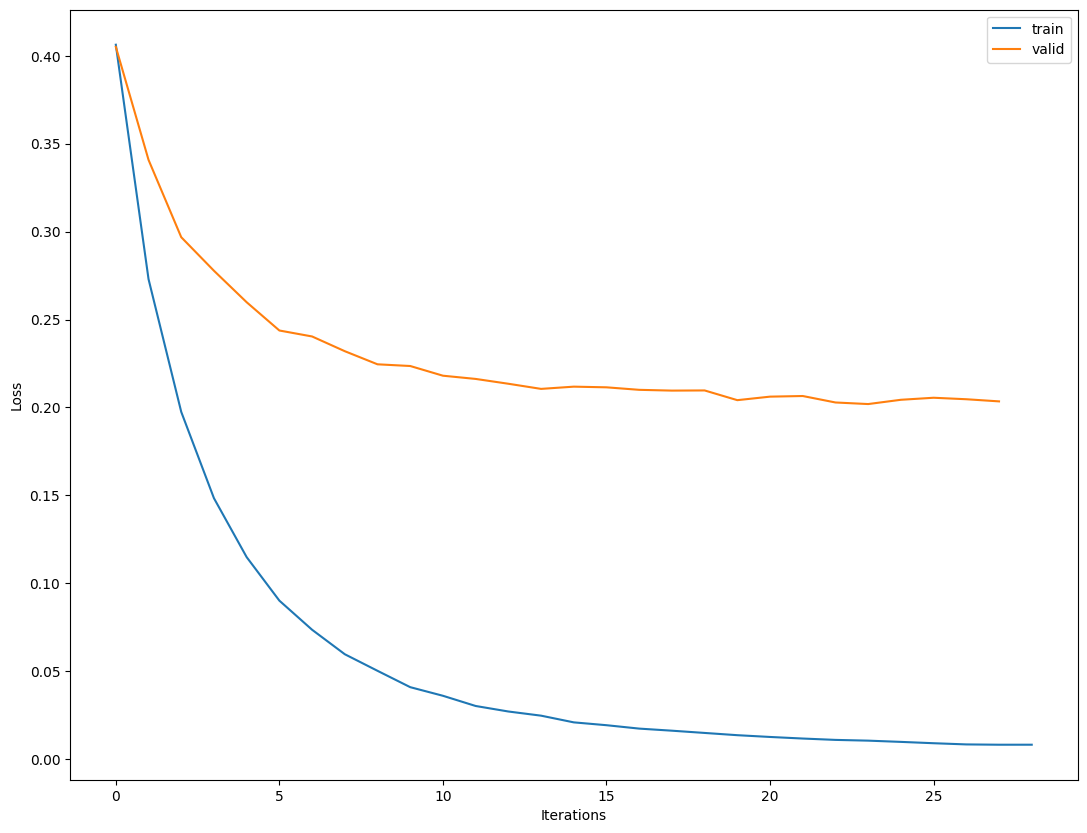

In [10]:
fig = plt.figure(figsize=(13, 10))

train_losses = loaded_stats['train_losses']
val_losses = loaded_stats['val_losses']

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Visualisation of Accuracy, Precision, Recall, F1-score

---



Text(0.5, 0, 'Iterations')

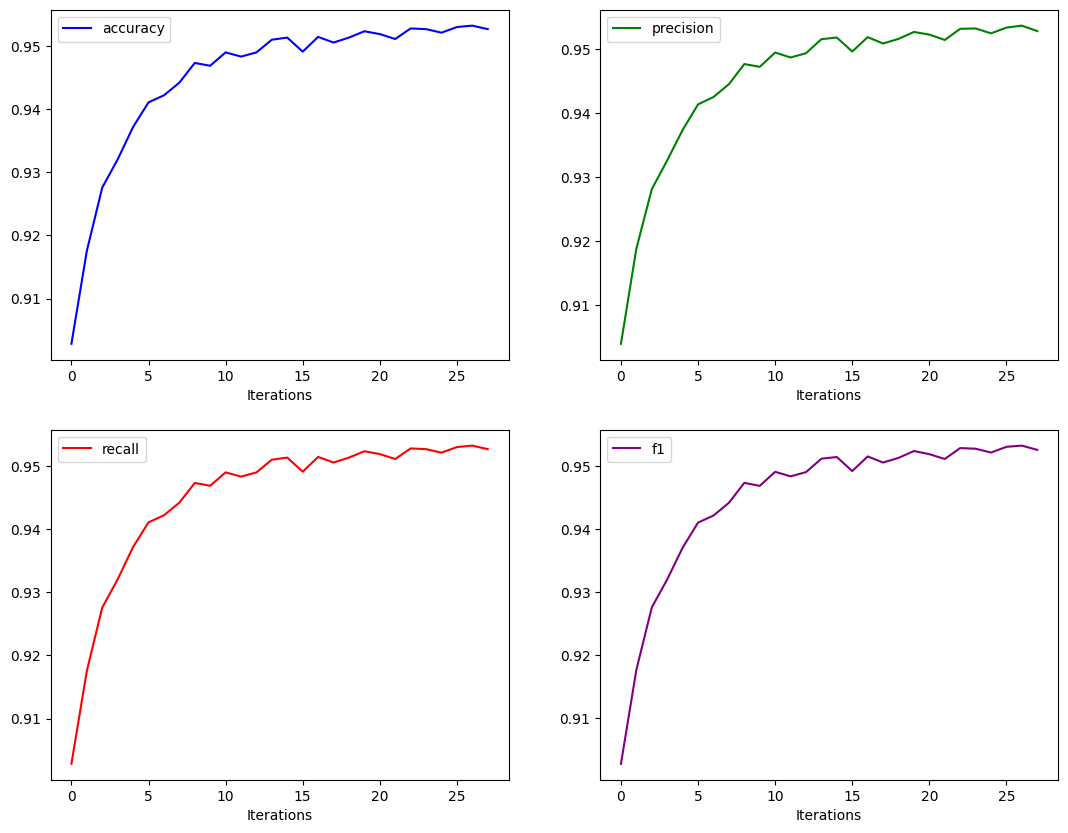

In [ ]:
fig = plt.figure(figsize=(13, 10))

val_acc = loaded_stats['val_accs']
precision = loaded_stats['val_precisions']
recall = loaded_stats['val_recalls']
f1 = loaded_stats['val_f1s']

plt.subplot(2, 2, 1)
plt.plot(val_acc, label='accuracy', color='blue')
plt.legend()
plt.xlabel('Iterations')

plt.subplot(2, 2, 2)
plt.plot(precision, label='precision', color='green')
plt.legend()
plt.xlabel('Iterations')

plt.subplot(2, 2, 3)
plt.plot(recall, label='recall', color='red')
plt.legend()
plt.xlabel('Iterations')

plt.subplot(2, 2, 4)
plt.plot(f1, label='f1', color='purple')
plt.legend()
plt.xlabel('Iterations')

# Visualisation of Confusion matrix

---



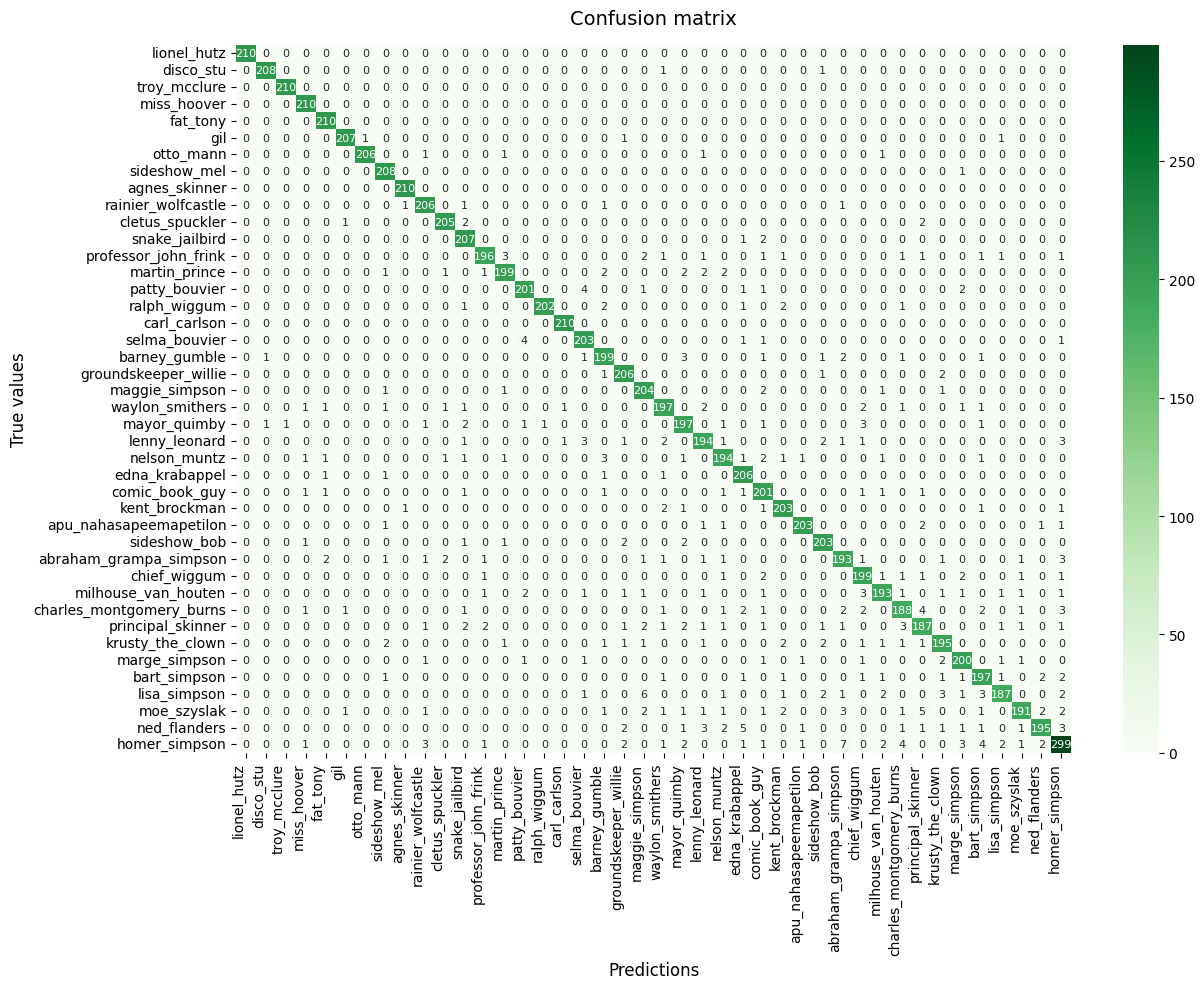

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = loaded_stats['best_confusion_matrix']

plt.figure(figsize=(13, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    annot_kws={"fontsize": 8},
    xticklabels=classes,
    yticklabels=classes,
)
ax.set_ylabel("True values", fontsize=12)
ax.set_xlabel("Predictions", fontsize=12)
ax.set_title("Confusion matrix", pad=15, fontsize=14)

plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Model testing

---



In [ ]:
def test_step(model):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            predictions = model(images)
            _, predicted = torch.max(predictions.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
accuracy_test = test_step(model)
accuracy_test

94.91943127962085

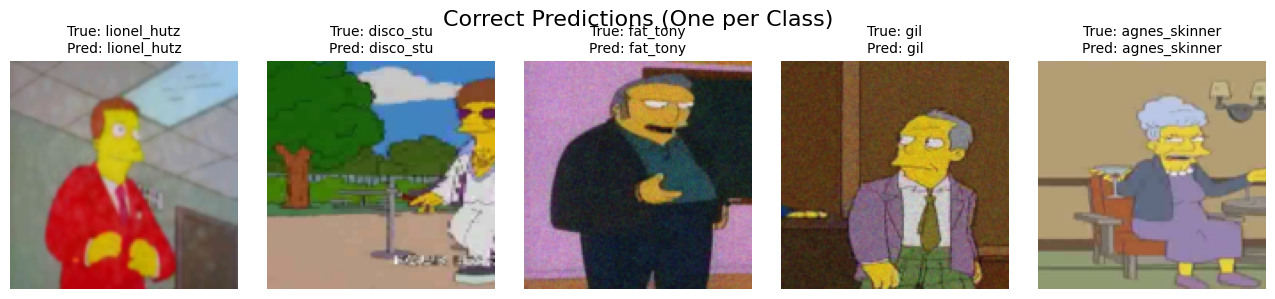

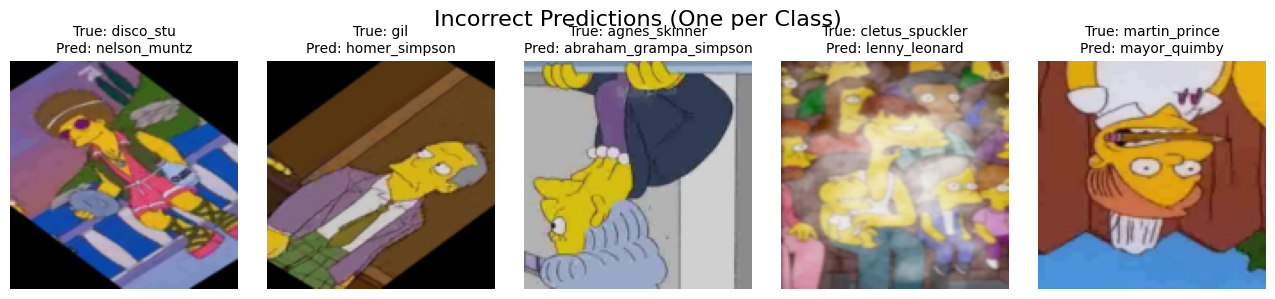

In [16]:
def visualize_predictions_by_class(model, test_loader, classes, num_samples=5):
    model.eval()
    correct_samples = {}
    incorrect_samples = {}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                true_class = labels[i].item()
                pred_class = preds[i].item()

                # Store correct predictions
                if pred_class == true_class and true_class not in correct_samples:
                    correct_samples[true_class] = (images[i], true_class, pred_class)

                # Store incorrect predictions
                elif pred_class != true_class and true_class not in incorrect_samples:
                    incorrect_samples[true_class] = (images[i], true_class, pred_class)

                # Stop when we have enough samples
                if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                    break

            if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                break

    # Convert to lists and select the required number of samples
    correct_samples = list(correct_samples.values())[:num_samples]
    incorrect_samples = list(incorrect_samples.values())[:num_samples]

    # Plot correct predictions
    plt.figure(figsize=(13, 3))
    plt.suptitle('Correct Predictions (One per Class)', fontsize=16)
    for i, (img, true_class, pred_class) in enumerate(correct_samples):
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'True: {classes[true_class]}\nPred: {classes[pred_class]}', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot incorrect predictions
    plt.figure(figsize=(13, 3))
    plt.suptitle('Incorrect Predictions (One per Class)', fontsize=16)
    for i, (img, true_class, pred_class) in enumerate(incorrect_samples):
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'True: {classes[true_class]}\nPred: {classes[pred_class]}', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_predictions_by_class(model, val_loader, classes, num_samples=5)